# Import

In [ ]:
import logging
import langchain
langchain.debug = True
logging.basicConfig(level=logging.INFO)

import json
import os
import time

from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.types import interrupt, Command
from models.gmail_manager import GmailManager
from models.calendar_manager import CalendarManager
from tools.custum_tools import (
    collect_tools, 
    get_time_now, 
    system_prompt, 
    get_last_n_email_ids,
    open_llm_connection,
    create_graph,
    call_graph_without_logs,
)
from langsmith import traceable
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import clear_output, Image, display
from dotenv import load_dotenv

# Configuration

In [2]:
load_dotenv()

config = {'configurable': {'thread_id': '1'}}
FIREWORKS_API_KEY = os.getenv("FIREWORKS_API_KEY")
CLIENT_SECRETS_FILE = os.getenv("CLIENT_SECRETS_FILE")
TOKEN_FILE = os.getenv("TOKEN_FILE")
MYEMAIL = os.getenv("MYEMAIL")

In [3]:
gm = GmailManager(client_secrets_file=CLIENT_SECRETS_FILE, token_file=TOKEN_FILE)
cm = CalendarManager(client_secrets_file=CLIENT_SECRETS_FILE, token_file=TOKEN_FILE)

# LLM Instanciation

In [4]:
llm = open_llm_connection(api_key=FIREWORKS_API_KEY)

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x000001806B8A02D0>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x000001806B8A1F50>


# Body

In [5]:
tools = collect_tools(gm) + collect_tools(cm) + [get_time_now]
graph = create_graph(tools, llm)

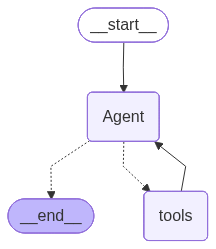

In [6]:
display(Image(graph.get_graph().draw_mermaid_png(background_color="dark")))

In [ ]:
@traceable(project_name=os.getenv("LANGSMITH_PROJECT"))
def call_graph(graph, query: str = None, prompt: str = None, config: dict = None):
    call_graph_without_logs(graph, query, prompt, config)
thread_configs = {}

In [ ]:
while True:
    print("Checking for new emails to process...")
    for i, email_id in enumerate(get_last_n_email_ids(gm=gm, me=MYEMAIL, n=5)):
        if thread_configs.get(email_id, None) is None:
            thread_configs[email_id] = {'memory': MemorySaver(), 'config': {'thread_id': email_id}}
        config = thread_configs[email_id]['config']
        memory = thread_configs[email_id]['memory']
        print(f"Processing email {i+1} with ID: {email_id}")
        print("-------------------------------------------------------------------------------")
        graph = create_graph(tools, llm, memory=memory)
        print(call_graph(graph, query=f"Un nouveau email est arrivée avec message_id={email_id}", prompt=system_prompt(), config=config))
    print("Sleeping for 10 seconds before checking again...")
    time.sleep(15)
    clear_output(wait=True)

Processing email 1 with ID: 19aa2a9c05a7ea70
-------------------------------------------------------------------------------
None
Sleeping for 10 seconds before checking again...
Processing email 2 with ID: 19aa291313b9af73
-------------------------------------------------------------------------------
None
Sleeping for 10 seconds before checking again...
Processing email 3 with ID: 19aa28291c277f2b
-------------------------------------------------------------------------------
None
Sleeping for 10 seconds before checking again...
Processing email 4 with ID: 19aa2713bb327534
-------------------------------------------------------------------------------
None
Sleeping for 10 seconds before checking again...
